In [4]:
import numpy as np
import cv2 # opencv, installed with pip
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Try with test images

In [5]:
img = cv2.imread('../testImages/Su2.jpg')
img.shape

(430, 690, 3)

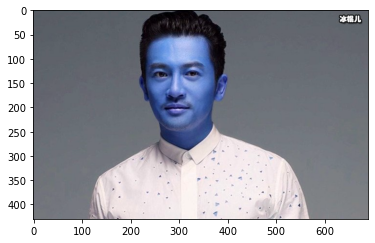

In [6]:
plt.imshow(img)

In [122]:
# Using cv2.cvtColor() method
# Using cv2.COLOR_BGR2GRAY color space conversion code
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(430, 690)

In [123]:
gray

array([[ 92,  92,  92, ...,  96,  96,  96],
       [ 96,  96,  96, ..., 104, 104, 104],
       [ 95,  95,  95, ...,  99,  99,  99],
       ...,
       [121, 121, 121, ..., 132, 131, 131],
       [121, 121, 121, ..., 132, 130, 130],
       [119, 119, 119, ..., 130, 129, 129]], dtype=uint8)

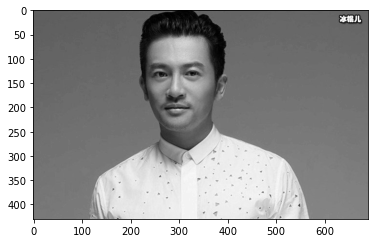

In [124]:
plt.imshow(gray, cmap='gray')

In [125]:
face_cascade = cv2.CascadeClassifier('../opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('../opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces
# Detects objects of different sizes in the input image. 
# The detected objects are returned as a list of rectangles.

array([[209,  62, 177, 177]], dtype=int32)

In [126]:
(x,y,w,h) = faces[0]
x,y,w,h

(209, 62, 177, 177)

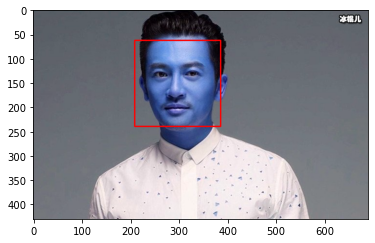

In [127]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

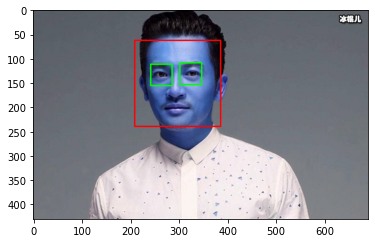

In [128]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

# Preprocessing: Crop the facial region of the image

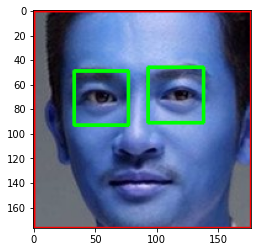

In [129]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [130]:
cropped_img = np.array(roi_color)
cropped_img.shape

(177, 177, 3)

## Preprocessing: Use wavelet transform as a feature for traning our model

This function does wavelet transform on the colored image

In [230]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

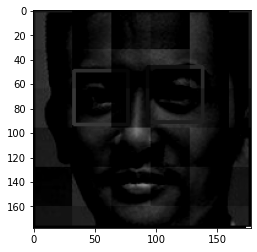

In [132]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

## Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region

### Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [133]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path) # read image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # change image to gray color mode
    faces = face_cascade.detectMultiScale(gray, 1.3, 5) # detect face from the image
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

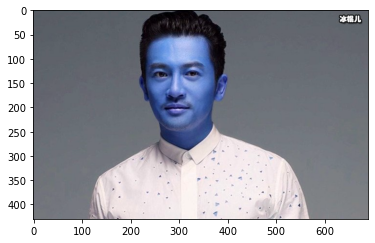

In [134]:
original_image = cv2.imread('../testImages/Su2.jpg')
plt.imshow(original_image)

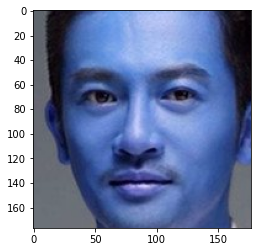

In [135]:
cropped_image = get_cropped_image_if_2_eyes('../testImages/Su2.jpg')
plt.imshow(cropped_image)

### Let's try this function on some bad images

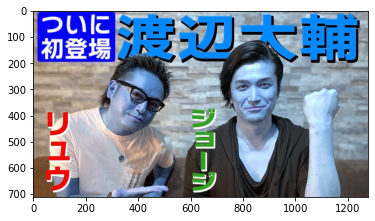

In [136]:
original_image = cv2.imread('../testImages/Random.jpg')
plt.imshow(original_image)

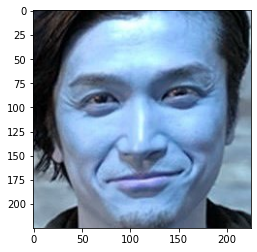

In [137]:
cropped_image = get_cropped_image_if_2_eyes('../testImages/Random.jpg')
plt.imshow(cropped_image)

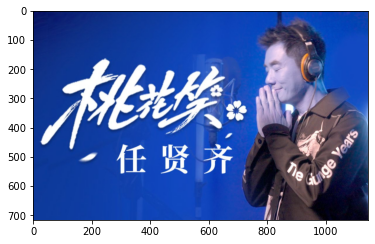

In [138]:
original_image = cv2.imread('../testImages/This.jpg')
plt.imshow(original_image)

In [139]:
cropped_image = get_cropped_image_if_2_eyes('../testImages/This.jpg')
cropped_image # no output

# Now preprocess all raw images 

In [140]:
path_to_data = "../RawImages/"
path_to_cr_data = "../cropped/"

In [141]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [142]:
img_dirs

['../RawImages/DuDW',
 '../RawImages/ZhouJL',
 '../RawImages/RenKe',
 '../RawImages/ZhangZY',
 '../RawImages/RenXQ',
 '../RawImages/LiJ',
 '../RawImages/WuKQ',
 '../RawImages/SuYP']

### Here it creates dir to store cropped data and deletes existing folders
### Be cautious whether or not you want to redo this process!!!

In [143]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data) # remove the dir if existing
os.mkdir(path_to_cr_data)

In [144]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1 # count number of people
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = [] # initiate the dict for this name
    
    for entry in os.scandir(img_dir):
        # print("Working on ",entry)
        # only continue if entry is a jpg file
        if not entry.name.startswith('.'): # in fact this is not necessary with the next line
            if entry.name.endswith('.jpg'):
                roi_color = get_cropped_image_if_2_eyes(entry.path) # use written function to detect if there are 2 eyes
        
                if roi_color is not None:
                    cropped_folder = path_to_cr_data + celebrity_name # subfolder path under cropped 
                    if not os.path.exists(cropped_folder):
                        os.makedirs(cropped_folder)
                        cropped_image_dirs.append(cropped_folder)
                        print("Generating cropped images in folder: ",cropped_folder)
                    cropped_file_name = celebrity_name + str(count) + ".png" # new file name
                    cropped_file_path = cropped_folder + "/" + cropped_file_name # new file path
                    cv2.imwrite(cropped_file_path, roi_color) # write image
                    celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                    count += 1

Generating cropped images in folder:  ../cropped/DuDW
Generating cropped images in folder:  ../cropped/ZhouJL
Generating cropped images in folder:  ../cropped/RenKe
Generating cropped images in folder:  ../cropped/ZhangZY
Generating cropped images in folder:  ../cropped/RenXQ
Generating cropped images in folder:  ../cropped/LiJ
Generating cropped images in folder:  ../cropped/WuKQ
Generating cropped images in folder:  ../cropped/SuYP


## Manually examine cropped folder and delete any unwanted images before continuing

In [231]:
cropped_image_dirs

['../cropped/DuDW',
 '../cropped/ZhouJL',
 '../cropped/RenKe',
 '../cropped/ZhangZY',
 '../cropped/RenXQ',
 '../cropped/LiJ',
 '../cropped/WuKQ',
 '../cropped/SuYP']

In [237]:
celebrity_file_names_dict = {}
count_file = {} # added this to count the number of images of each name
for img_dir in cropped_image_dirs:
        celebrity_name = img_dir.split('/')[-1]
        file_list = [] # initialize a vector to store all file paths under this name folder
        count = 0
        for entry in os.scandir(img_dir):
            if entry.name.endswith('.png'): # only continue with png image file
                file_list.append(entry.path)
                count = count + 1
            celebrity_file_names_dict[celebrity_name] = file_list # assign the appended file list to dict
            count_file[celebrity_name] = count


In [236]:
count_file

{'DuDW': 42,
 'ZhouJL': 19,
 'RenKe': 12,
 'ZhangZY': 11,
 'RenXQ': 38,
 'LiJ': 31,
 'WuKQ': 34,
 'SuYP': 48}

In [238]:
celebrity_file_names_dict

{'DuDW': ['../cropped/DuDW/DuDW33.png',
  '../cropped/DuDW/DuDW27.png',
  '../cropped/DuDW/DuDW26.png',
  '../cropped/DuDW/DuDW32.png',
  '../cropped/DuDW/DuDW18.png',
  '../cropped/DuDW/DuDW24.png',
  '../cropped/DuDW/DuDW31.png',
  '../cropped/DuDW/DuDW25.png',
  '../cropped/DuDW/DuDW21.png',
  '../cropped/DuDW/DuDW35.png',
  '../cropped/DuDW/DuDW34.png',
  '../cropped/DuDW/DuDW20.png',
  '../cropped/DuDW/DuDW9.png',
  '../cropped/DuDW/DuDW36.png',
  '../cropped/DuDW/DuDW22.png',
  '../cropped/DuDW/DuDW23.png',
  '../cropped/DuDW/DuDW8.png',
  '../cropped/DuDW/DuDW50.png',
  '../cropped/DuDW/DuDW44.png',
  '../cropped/DuDW/DuDW45.png',
  '../cropped/DuDW/DuDW51.png',
  '../cropped/DuDW/DuDW47.png',
  '../cropped/DuDW/DuDW52.png',
  '../cropped/DuDW/DuDW46.png',
  '../cropped/DuDW/DuDW42.png',
  '../cropped/DuDW/DuDW43.png',
  '../cropped/DuDW/DuDW5.png',
  '../cropped/DuDW/DuDW12.png',
  '../cropped/DuDW/DuDW13.png',
  '../cropped/DuDW/DuDW4.png',
  '../cropped/DuDW/DuDW6.png',
  '..

In [224]:
celebrity_file_names_dict.keys()

dict_keys(['DuDW', 'ZhouJL', 'RenKe', 'ZhangZY', 'RenXQ', 'LiJ', 'WuKQ', 'SuYP'])

### Create a mapping between names and numerical labels

In [239]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'DuDW': 0,
 'ZhouJL': 1,
 'RenKe': 2,
 'ZhangZY': 3,
 'RenXQ': 4,
 'LiJ': 5,
 'WuKQ': 6,
 'SuYP': 7}

## Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [240]:
len(celebrity_file_names_dict.items())

8

In [241]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  

In [218]:
len(X[0])

4096

In [197]:
X[0]

array([[10],
       [ 9],
       [13],
       ...,
       [18],
       [45],
       [ 3]], dtype=uint8)

In [198]:
np.size(y)

244

In [242]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(235, 4096)

# Data cleaning process is done. Now we are ready to train our model
We will use SVM with rbf kernel tuned with heuristic finetuning

In [219]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.5254237288135594

In [204]:
len(X_test)

61

In [258]:
len(X_train)

176

In [244]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.38      0.33      0.35         9
           1       0.33      0.50      0.40         2
           2       1.00      0.67      0.80         3
           3       1.00      0.50      0.67         2
           4       0.67      0.67      0.67         9
           5       1.00      0.33      0.50        12
           6       0.67      0.67      0.67        12
           7       0.30      0.60      0.40        10

    accuracy                           0.53        59
   macro avg       0.67      0.53      0.56        59
weighted avg       0.64      0.53      0.54        59



### My own word to explain what they mean:
#### precision: when the model predicts it belongs to this group, how many of them really belong to this group?
#### recall (aka sensitivity): Among all items that belong to this group, how many of them were correctly predicted?
#### specificity: Among all items that don't belong to this group, how many of them were correctly rejected?
#### f1-score: a balance between precision and recall, calculated as 2 * precision * recall / ( precision + recall )


# Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [245]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV # used to auto tune parameters

In [246]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [247]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model']) # scale data before modeling
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.447937,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.391905,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.470952,{'logisticregression__C': 1}


In [248]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

### Notice the relation between training data, test data, validation data
Check this out if you are confused!
https://machinelearningmastery.com/difference-test-validation-datasets/

#### First oftentimes test data and validation data are used interchangeably. 
#### The distinction is meaningful when you need to tune your hyper parameters. In this case, validation data are used to help with tuning, and test data are held out to test the model performance with tuned hyper parameters.

#### Reference to a “validation dataset” disappears if the practitioner is choosing to tune model hyperparameters using k-fold cross-validation with the training dataset. (as in this project)

#### Reference to the “test dataset” too may disappear if the cross-validation of model hyperparameters using the training dataset is nested within a broader cross-validation of the model.

In [249]:
best_estimators['svm'].score(X_test,y_test)

0.5423728813559322

In [250]:
best_estimators['random_forest'].score(X_test,y_test)

0.2711864406779661

In [251]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.576271186440678

In [252]:
best_clf = best_estimators['svm']

In [253]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[5, 0, 0, 0, 0, 0, 1, 3],
       [0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 3, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0],
       [1, 4, 0, 0, 3, 0, 0, 1],
       [0, 1, 1, 0, 3, 4, 1, 2],
       [1, 1, 0, 0, 0, 0, 9, 1],
       [0, 1, 0, 0, 1, 1, 1, 6]])

Text(69.0, 0.5, 'Truth')

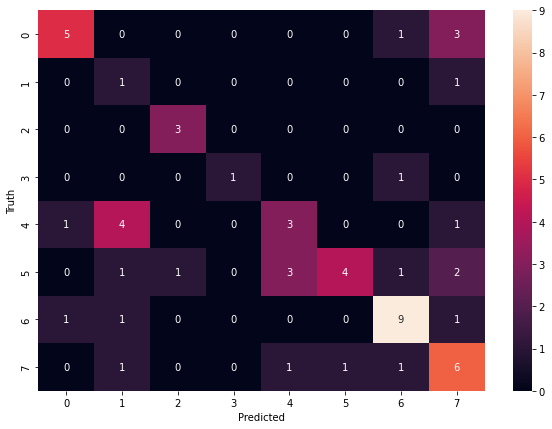

In [254]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [257]:
class_dict

{'DuDW': 0,
 'ZhouJL': 1,
 'RenKe': 2,
 'ZhangZY': 3,
 'RenXQ': 4,
 'LiJ': 5,
 'WuKQ': 6,
 'SuYP': 7}

In [255]:
!pip install joblib # install joblib package
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [256]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))